## Gas Power Plant scenario
In this scenario we add a gas power plant to the baseline scenario and look for the "sweet spot" of prices on carbon such that coal, wind and gas are used at the same time. 

In [1010]:
import pandas as pd
import ixmp
import message_ix

from message_ix.utils import make_df

%matplotlib inline

In [1011]:
mp = ixmp.Platform()

INFO:ixmp.backend.jdbc:launching ixmp.Platform connected to jdbc:hsqldb:file:C:/Users/Carlo/.local/share/ixmp/localdb/default


In [1012]:
model = 'Westeros Electrified'

base = message_ix.Scenario(mp, model=model, scenario='baseline')
scen = base.clone(model, 'Addition of a gas power plant','introducing a gas power plant in Westeros',
                  keep_solution=False)
scen.check_out()

In [1013]:
year_df = scen.vintage_and_active_years()
vintage_years, act_years = year_df['year_vtg'], year_df['year_act']
model_horizon = scen.set('year')
country = 'Westeros'

In [1014]:
base = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': '-',
}

base_input = make_df(base, node_origin=country, time_origin='year')
base_output = make_df(base, node_dest=country, time_dest='year')

## Introducing Gas Power Plant

In [1015]:
scen.add_set("technology", ['gas_ppl'])

Adding a gas power plant to the scenario defining the commodity and level.

In [1016]:
gas_out = make_df(base_output, technology='gas_ppl', commodity='electricity', 
                   level='secondary', value=1.)
scen.add_par('output', gas_out)

## Operational Constraints and Parameters

Here, we call make_df() and add_par() in a loop to execute similar code for four technologies:

In [1017]:
base_capacity_factor = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'time': 'year',
    'unit': '-',
}

In [1018]:
capacity_factor = {
    'gas_ppl': 1,
    'coal_ppl': 1,
    'wind_ppl': 0.36,
    'bulb': 1, 
}

for tec, val in capacity_factor.items():
    df = make_df(base_capacity_factor, technology=tec, value=val)
    scen.add_par('capacity_factor', df)

## Specifying the lifetime of a gas power plant
Source: https://www.mdpi.com/2071-1050/11/10/2912/

In [1019]:
base_technical_lifetime = {
    'node_loc': country,
    'year_vtg': model_horizon,
    'unit': 'y',
}

In [1020]:
lifetime = {
    'gas_ppl' : 25, # Source: https://www.mdpi.com/2071-1050/11/10/2912/
    'coal_ppl': 20,
    'wind_ppl': 20,
    'bulb': 1,
}

for tec, val in lifetime.items():
    df = make_df(base_technical_lifetime, technology=tec, value=val)
    scen.add_par('technical_lifetime', df)

## Technological Diffusion and Contraction

In [1021]:
base_growth = {
    'node_loc': country,
    'year_act': model_horizon,
    'time': 'year',
    'unit': '-',
}
growth_technologies = [
    "gas_ppl",
    "coal_ppl", 
    "wind_ppl", 
]

for tec in growth_technologies:
    df = make_df(base_growth, technology=tec, value=0.1) 
    scen.add_par('growth_activity_up', df)

## Defining an Energy Mix (Model Calibration)

In [1022]:
history = [690]
demand_per_year = 40 * 12 * 1000 / 8760
grid_efficiency = 0.9
historic_demand = 0.85 * demand_per_year
historic_generation = historic_demand / grid_efficiency
coal_fraction = 0.6
gas_fraction = 0.2
base_capacity = {
    'node_loc': country,
    'year_vtg': history,
    'unit': 'GWa',
}

base_activity = {
    'node_loc': country,
    'year_act': history,
    'mode': 'standard',
    'time': 'year',
    'unit': 'GWa',
}

In [1023]:
old_activity = {
    'coal_ppl': coal_fraction * historic_generation,
    'wind_ppl': (1 - coal_fraction - gas_fraction) * historic_generation,
    'gas_ppl': gas_fraction * historic_generation,

}

for tec, val in old_activity.items():
    df = make_df(base_activity, technology=tec, value=val)
    scen.add_par('historical_activity', df)


In [1024]:
act_to_cap = {
    'gas_ppl': 1 / 10 / capacity_factor['gas_ppl'] / 2.5, # 25 years lifetime
    'coal_ppl': 1 / 10 / capacity_factor['coal_ppl'] / 2, # 20 year lifetime
    'wind_ppl': 1 / 10 / capacity_factor['wind_ppl'] / 2,
}

for tec in act_to_cap:
    value = old_activity[tec] * act_to_cap[tec]
    df = make_df(base_capacity, technology=tec, value=value)
    scen.add_par('historical_new_capacity', df)

## Objective Function

In [1025]:
scen.add_par("interestrate", model_horizon, value=0.05, unit='-')

In [1026]:
base_inv_cost = {
    'node_loc': country,
    'year_vtg': model_horizon,
    'unit': 'USD/kW',
}

# Adding a new unit to the library
mp.add_unit('USD/kW')   

INFO:root:unit `USD/kW` is already defined in the platform instance


In [1027]:
# in $ / kW (specific investment cost)
costs = {
    'gas_ppl': 1200, # Source: https://www.econstor.eu/bitstream/10419/80348/1/757528015.pdf
    'coal_ppl': 500,
    'wind_ppl': 1500,
    'bulb': 5,
}

for tec, val in costs.items():
    df = make_df(base_inv_cost, technology=tec, value=val)
    scen.add_par('inv_cost', df)

## Fixed O&M Costs

In [1028]:
base_fix_cost = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'unit': 'USD/kWa',
}

In [1029]:
costs = {
    'gas_ppl': 32, # https://iea-etsap.org/E-TechDS/PDF/E02-gas_fired_power-GS-AD-gct.pdf (4 % of the investment costs)
    'coal_ppl': 30,
    'wind_ppl': 10,
}

for tec, val in costs.items():
    df = make_df(base_fix_cost, technology=tec, value=val)
    scen.add_par('fix_cost', df)

## Variable O&M Costs


In [1030]:
base_var_cost = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': 'USD/kWa',
}

In [1031]:
costs = {
    'gas_ppl': 39.15, # https://www.eia.gov/analysis/studies/powerplants/capitalcost/pdf/capcost_assumption.pdf
    'coal_ppl': 30,
    'grid': 50,
}

for tec, val in costs.items():
    df = make_df(base_var_cost, technology=tec, value=val)
    scen.add_par('var_cost', df)

## Solve the Model

In [1032]:
from message_ix import log

log.info('version number prior to commit: {}'.format(scen.version))

scen.commit(comment='Model of Westeros electrification with addition of gas power plant')

log.info('version number prior committing to the database: {}'.format(scen.version))

INFO:message_ix:version number prior to commit: 15
INFO:message_ix:version number prior committing to the database: 15


In [1033]:
scen.solve()

In [1034]:
scen.var('OBJ')['lvl']

216526.796875

## Plotting Results

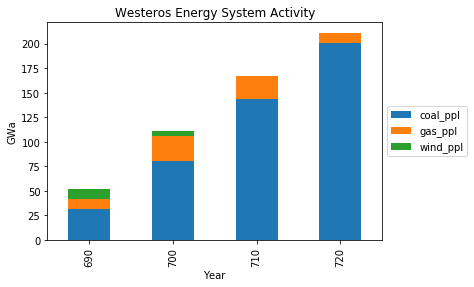

In [1035]:
from tools import Plots
p = Plots(scen, country, firstyear=model_horizon[0])
p.plot_activity(baseyear=True, subset=['gas_ppl', 'coal_ppl', 'wind_ppl'])

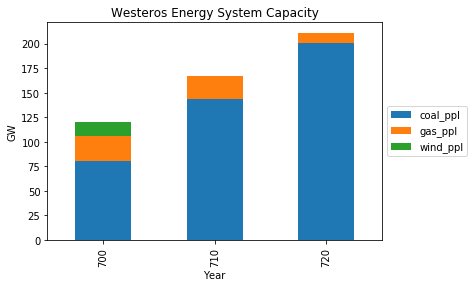

In [1036]:
p.plot_capacity(baseyear=True, subset=['gas_ppl', 'coal_ppl', 'wind_ppl'])

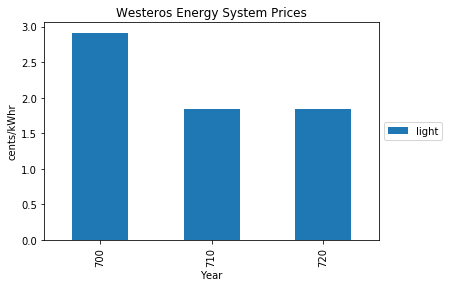

In [1037]:
p.plot_prices(subset=['light'], baseyear=True)

## Introducing Emissions
For this purpose we clone the baseline scenario (to scen_emiss)

In [1038]:
scen_emiss = scen.clone(model, 'emission_bound','introducing emissions',
                  keep_solution=False)
scen_emiss.check_out()
# first we introduce the emission of CO2 and the emission category GHG
scen_emiss.add_set('emission', 'CO2')
scen_emiss.add_cat('emission', 'GHG', 'CO2')

# we now add CO2 emissions to the coal powerplant
base_emission_factor = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'unit': 'tCO2/kWa',
}

# adding new units to the model library (needed only once)
mp.add_unit('tCO2/kWa')
mp.add_unit('MtCO2')

emission_factor_gas = make_df(base_emission_factor, technology= 'gas_ppl', emission= 'CO2', value = 3.1) # https://www.ngsa.org/download/Leidos-Update-2016-emissions.pdf
emission_factor_coal = make_df(base_emission_factor, technology= 'coal_ppl', emission= 'CO2', value = 7.4)
scen_emiss.add_par('emission_factor', emission_factor_gas)
scen_emiss.add_par('emission_factor', emission_factor_coal)

INFO:root:unit `tCO2/kWa` is already defined in the platform instance
INFO:root:unit `MtCO2` is already defined in the platform instance


##  Introducing emission taxes

In [1039]:
# emission_prices_by_year = scen.var('PRICE_EMISSION')
scen_emiss.add_set('type_year', [700, 710, 720])

base_tax_emission = {
    'node': 'Westeros',
    'type_year': [700, 710, 720],
    'type_tec': 'all',
    'unit': 'USD/tCO2',
    'type_emission': 'GHG',
    'value': [25, 25, 30]
#     'value': emission_prices.set_index('year').lvl
}

# in case you need to add the new unit to the platform
mp.add_unit('USD/tCO2')

tax_emission = make_df(base_tax_emission)
scen_emiss.add_par('tax_emission', tax_emission)
scen_emiss.par('tax_emission')

INFO:root:unit `USD/tCO2` is already defined in the platform instance


,node,type_emission,type_tec,type_year,value,unit
0,Westeros,GHG,all,700,25.0,USD/tCO2
1,Westeros,GHG,all,710,25.0,USD/tCO2
2,Westeros,GHG,all,720,30.0,USD/tCO2


In [1040]:
scen_emiss.commit(comment='setting taxes on emissions')

In [1041]:
scen_emiss.solve()

In [1042]:
emission_prices = scen.var('PRICE_EMISSION')

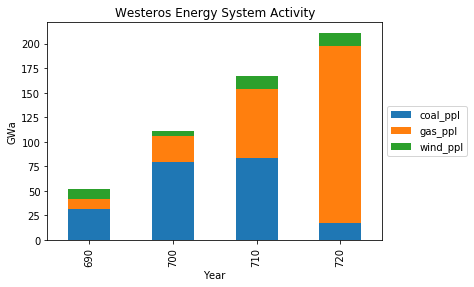

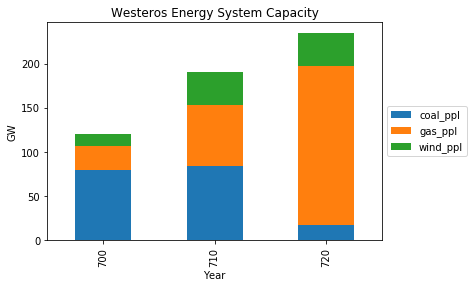

In [1043]:
from tools import Plots
p = Plots(scen_emiss, country, firstyear=model_horizon[0])
p.plot_activity(baseyear=True, subset=['gas_ppl', 'coal_ppl', 'wind_ppl'])
p.plot_capacity(baseyear=True, subset=['gas_ppl', 'coal_ppl', 'wind_ppl'])

It has been shown that if the emission prices in the year 700, 710 and 720 are 25, 25 and 30 USD/tCO2 respectively, there s a "sweetspot" in which coal, wind and gas are used simultaneously.